# HW2 Reproducibility, a biologist's perspective
## Cell States beyond transcriptomics: Integrating structural organization and gene expression in hiPSC-derived cardiomyocytes, Gerbin et al 2021

Rebecca Martin, Sam Rosen, Breanna Takacs, Gabriela V. Torres  

# Outline of work done

I. Read the paper and discussed main findings and pitfalls of the study (1 hour)

II. Understanding and attempting to execute original code for machine learning and data analysis (6 hour)

III. Tried to download source data onto server but broke it (2 hour)

IV. Cloned the scripts used to generate the figures onto Github. Got them to work with original CSV data files from Gerbin et al 2021 study (2 hour)

## I. Main findings of Gerbin et al 2021

- Quantified subcellular organization and gene expression in >30,000 individual hiPSC-CMs

- This is a big deal because even though mRNA abundance of some genes correlates with organization, these two metrics are heterogeneous and often uncorrelated, and therefore gene expression alone is not enough to classify cell states

- Cells are dynamic, they don’t always look the same and are constantly responding to any changes in their environment. Thus, they propose that cell states be described using a more comprehensive approach that accounts for space, time, and function

## II. Understanding original code (fish_morphology_code)

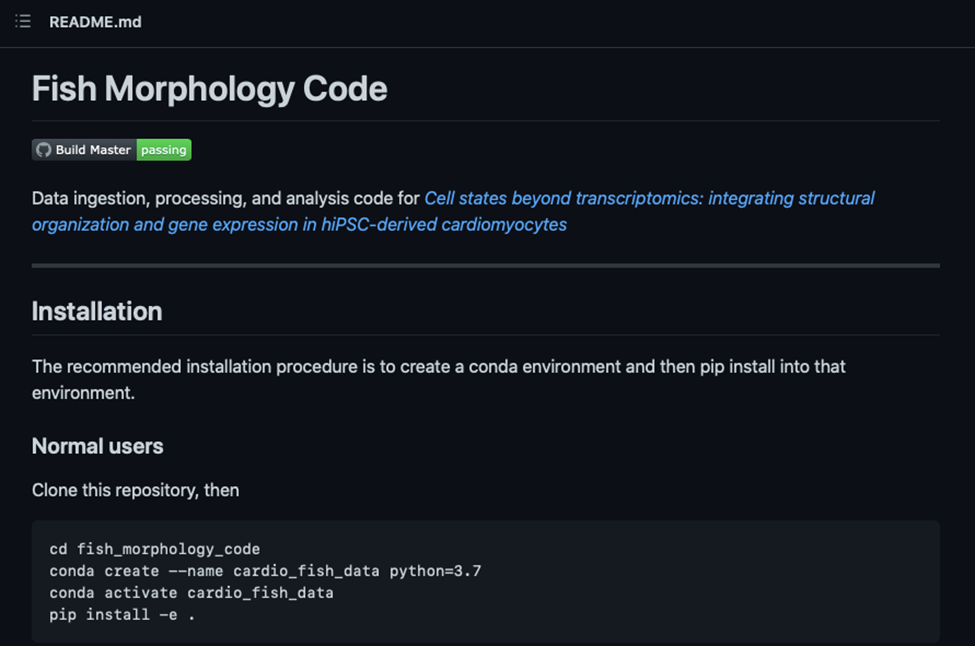

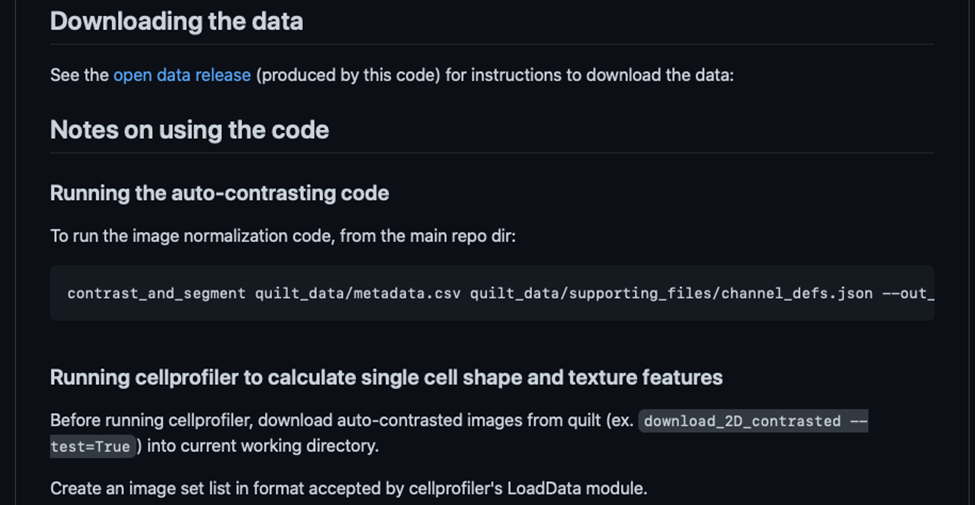

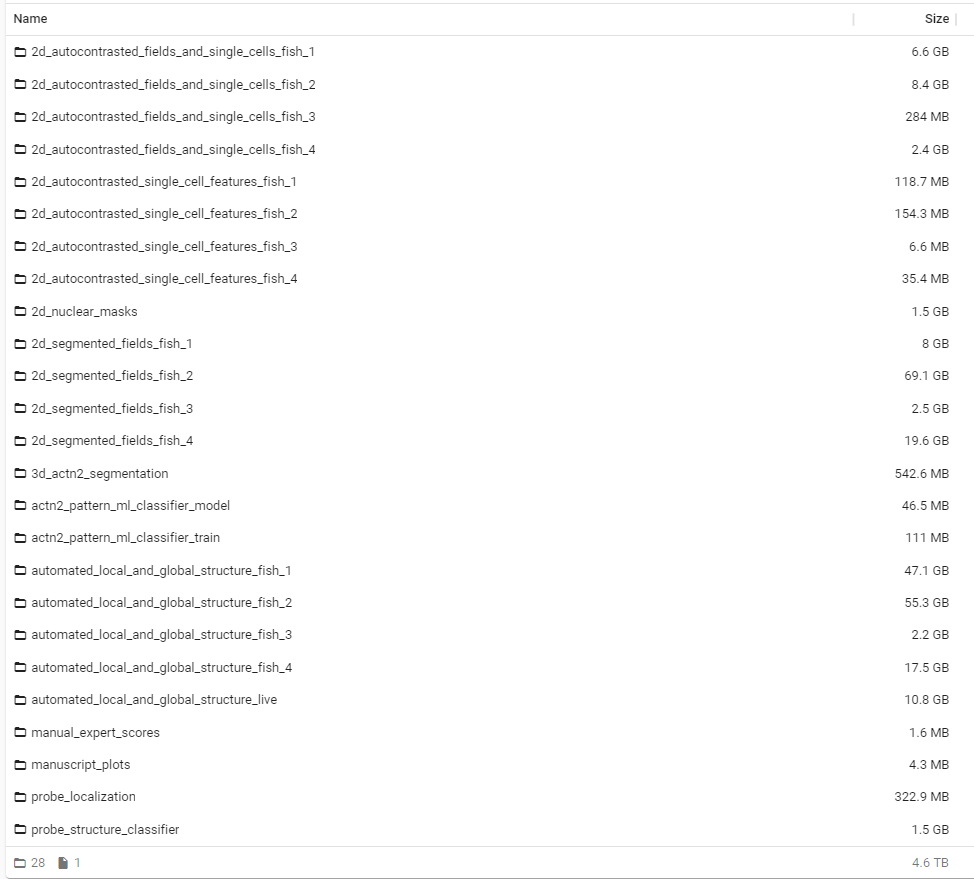

## III. Using source data in CNN-based classifier

- Located the file that trains the CNN-based classifier for EGFP-alpha-actinin-2 pattern
    - model_training.py in fish_morphology_code/fish_morphology_code/processing/structure_organization/local_organization/train

- Was unable to get the classifier to work; Becky has had their server privileges revoked
  - Had recurring issues with AllenCellModeling packages (aicsimageio and aicspylibczi)

## IV. Figure generation (fish_morphology_code_notebook)

- Located and ran the appropriate files in fish_morphology_code that use data from the paper and outputs the figures from the paper
  - Manuscript plots with filtered data from AllenCellModeling/fish_morphology_manuscript_notebook

In [1]:
!pip install anndata

In [2]:
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pingouin as pg
from scipy.stats import spearmanr
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import quilt3

from analysis.notebook_utils import (
    DAY_18_COLOR,
    DAY_32_COLOR,
    DAY_COLOR_PALETTE,
    DAY_COLOR_PALETTE_THREE,
    BAR_PLOT_COLUMNS,
    SHORT_FEAT_NAME_MAP,
    BAR_PLOT_COLUMNS_SHORT,
    PROBE_ORDER,
    CI_EXTENT,
    FEATURE_TYPE_MAP,
    safe,
    get_regression_coef,
    boot_regression,
    ci_low,
    ci_high,
    make_reg_plot_ci_df,
    make_regression_bar_plot,
    get_pred_true,
    make_regression_scatter_plot,
    boot_spearmanr,
)

from matplotlib import cm
import analysis.plots
from sklearn.metrics import confusion_matrix

In [3]:
#p_manuscript_data = quilt3.Package.browse(
#        "tanyasg/revised_manuscript_plots", "s3://allencell-internal-quilt"
#)

# public package
p_manuscript_data = quilt3.Package.browse(
        "aics/integrated_transcriptomics_structural_organization_hipsc_cm", "s3://allencell"
)

Loading manifest: 100%|██████████| 63309/63309 [00:01<00:00, 32.3k/s]


In [4]:
p_manuscript_data["revised_manuscript_plots"].fetch(
    "figure_data"
)

Copying objects: 100%|██████████| 16.1M/16.1M [00:12<00:00, 1.30MB/s]


(local Package)
 └─README.md
 └─data.csv

In [5]:
SAVE=True

if SAVE:
    SAVE_DIR = Path("./plots")
    SAVE_DIR.mkdir(parents=True, exist_ok=True)

    save_dir_pngs = SAVE_DIR/"pngs"
    save_dir_svgs = SAVE_DIR/"svgs"
    save_dir_pngs.mkdir(parents=True, exist_ok=True)
    save_dir_svgs.mkdir(parents=True, exist_ok=True)

In [6]:
replate_groups = {
    "2019-05-17": 1,
    "2019-05-21": 2,
    "2019-05-24": 3,
    "2019-06-04": 4,
    "2020-06-07": 5,
    "2020-08-28": 6,
    "2020-09-08": 7
}

In [7]:
#df = pd.read_csv("../20201110_collate_revised_data/20201124_revised_plot_data.csv")
df = pd.read_csv("figure_data/data.csv")

C:\Users\breat\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
df["replate_group"] = [replate_groups[x] for x in df.replate_date]

In [9]:
feat_cols = [
    "Cell area (μm^2)",
    "Cell aspect ratio",
    "Fraction cell area background",
    "Fraction cell area diffuse/other",
    "Fraction cell area fibers",
    "Fraction cell area disorganized puncta",
    "Fraction cell area organized puncta",
    "Fraction cell area organized z-disks",
    "Max coefficient var",
    "Peak height",
    "Peak distance (μm)",
    "Cell age"
]

In [10]:
yvars_set1 = [
    "Fraction cell area background",
    "Fraction cell area diffuse/other",
    "Fraction cell area disorganized puncta",
    "Fraction cell area fibers",
    "Fraction cell area organized puncta",
    "Fraction cell area organized z-disks"
]

viridis = cm.get_cmap('viridis', len(yvars_set1))

### Figure 2F Heatmap of fraction area per class, cells sorted by fraction area of organized z-disc
Based on the deep-learning-based classification of local structural organization of alpha-actinin-2-mEGFP performed by Gerbin et al 2021, we generated the heatmap displaying the fraction of cell area consisting of organized z-disks for Day 18 and 32. An increased number of cells with a regular z-disk pattern was observed at the later time point. The average of day 18 and 32 (middle plot) shows an intriguing quantification of organized z-disks.

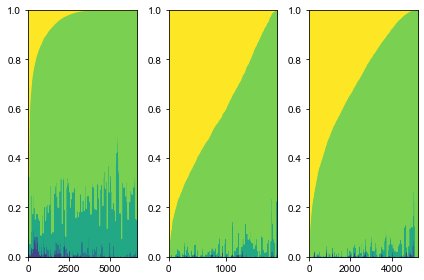

In [58]:
ranking_variable = 'Fraction cell area organized z-disks'
    
fig, ax = plt.subplots(1,3, figsize=(6,4))
for id_age, (age, df_age) in enumerate(df[df.Type=="FISH"].groupby("Cell age")):
    df_age = df_age.sort_values(ranking_variable, ascending=False)

    x = np.arange(df_age.shape[0])
    y = np.zeros(x.shape, dtype = np.float32)

    ax[id_age].set_ylim(0,1)
    ax[id_age].set_xlim(0,x.size)
    #print(age)
    for id_yvar, yvar in enumerate(yvars_set1):
        y_sup = y + df_age[yvar].values
        ax[id_age].fill_between(x[:],y1=y,y2=y_sup, color=viridis(id_yvar/len(yvars_set1)))
        y = y_sup
        
plt.tight_layout()

### Figure 3E
Plot of D18 and D32 cells as a scatter where axes represent how much of total cell area is z disk and global structural alignment (z disks and other structures). This image matches what we should expect for these CMs. D32 cells show higher total z disk area while D18 cells show lower z disk area. Z disks are an indication of CM maturity, so this figure makes sense. I find it interesting how global alignment doesn’t have much variation between the group, highlighting how functional components are a better indicator of maturity than overall organization.

In [12]:
df[df.Dataset.isin(["OldFish", "NewFish"])].shape

(11880, 66)

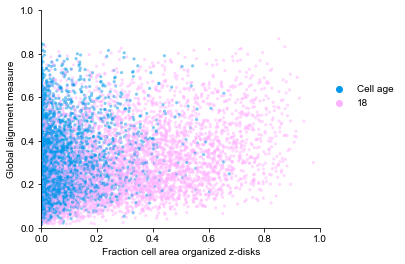

In [25]:
plt.figure(figsize=(5, 4))

plot_org_vs_stripes = sns.scatterplot(
    data=df[df.Dataset.isin(["OldFish", "NewFish"])].sample(frac=1, replace=False).reset_index(drop=True),
    x="Fraction cell area organized z-disks",
    y="Max coefficient var",
    hue="Cell age",
    hue_order=[18, 32],
    palette=DAY_COLOR_PALETTE,
    linewidth=0,
    alpha = 0.5,
    s=10,
)
plot_org_vs_stripes.set(ylabel="Global alignment measure");
plot_org_vs_stripes.set(xlim=(0, 1));
plot_org_vs_stripes.set(ylim=(0, 1));

handles, _ = plot_org_vs_stripes.get_legend_handles_labels()
plot_org_vs_stripes.legend(handles, ["Cell age", "18", "32"], bbox_to_anchor=(1.0, 0.7), frameon=False)
sns.despine()

### Figure 4F 
Takes 11 features reflecting cell features, local organization and global alignment and assigns them each a feature weight, which are used to determine a given cell’s combined organizational score. “Organized z-disks” and “Diffuse/Other” correlate most strongly with higher COS, which aligns with the expectation that these features correlate with more mature cells.

In [14]:
df_old = df[df.Dataset=="OldFish"].copy()

all_good_scores = (df_old.kg_structure_org_score > 0) & (df_old.mh_structure_org_score > 0)
df_old = df_old[all_good_scores]
df_old.shape

(4823, 66)

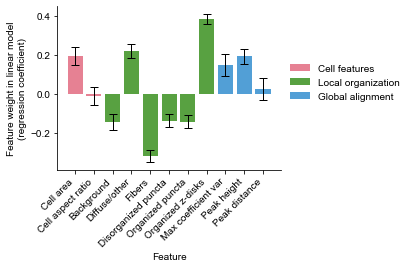

In [28]:
df_boot_reg = boot_regression(
    df_old,    N=1000,
    X_cols=BAR_PLOT_COLUMNS,
    y_col="Expert structural annotation score (mean)",
    weight_col="Expert structural annotation score (mean)",
)

reg_plot_ci_df = make_reg_plot_ci_df(df_boot_reg)
fig_bar, ax_bar = make_regression_bar_plot(reg_plot_ci_df, title="")

### Figure 5 
Takes 11 features reflecting cell features, local organization and global alignment and assigns them each a feature weight, which are used to determine a given cell’s combined organizational score. “Organized z-disks” and “Diffuse/Other” correlate most strongly with higher COS, which aligns with the expectation that these features correlate with more mature cells.

# V. Feedback on code reproducibility

- Our skillset is representative of researchers trained primarily in data collection and interpretation, not coding
  - We have the skills to culture cells, perform FISH, collect microscopy images, manually classify cells, and interpret results
  - We would like to be able to employ a machine learning tool like this in our projects to amplify and expand the abilities of our analyses, reduce time spent, and automate the process

- While we were able to generate figures from the data that Gerbin et al 2021 collected, we were not able to conduct ML to generate our own data on structural organization and gene expression in hiPSC-derived cardiomyocytes

- Many aspects of this code raise the barrier for entry for researchers trained in biology
    - Limited commenting
    - Challenging package installs 
    - No clear workflow
    - Headings in the python code does not match up with the figure labels in the paper

# Division of work
- Interpetting paper -- all members
- Understanding code -- all members 
- Attempt at machine learning -- Becky
- Figure interpretation and annotation -- all members
- Compiling, formatting, and figure generation for Jupyter notebook presentation file -- Breanna